

## Universal Patch Attack Training Script

This script trains a **universal adversarial patch** that makes a CLIP
image encoder think that many different natural images contain a specific
target concept (in our case, a **dog**):

1. **Target concept embedding**  
   - We take a clean dog image and encode it with CLIP ViT-B/32 to obtain a
     fixed reference feature vector.

2. **Patch initialization**  
   - We start from a random 96×96 RGB square (noise) that will become the
     adversarial patch.

3. **Training loop**  
   - In each step we sample a batch of random natural images from a folder.  
   - We paste the current patch onto each image at a random location and
     random scale.  
   - We encode these patched images with CLIP and compare their features to
     the dog reference feature.  
   - We update only the patch pixels (using gradient descent) so that the
     patched images look more “dog-like” to CLIP.

4. **Evaluation and saving**  
   - We visualize the learned patch.  
   - We test the patch on a random image to show that the dog similarity
     increases after patching.  
   - Finally we save the trained patch both as a tensor (`.pt`) and as a PNG
     image so that it can be reused in other notebooks (e.g., for LLaVA
     experiments or defense evaluation).

The rest of the script is organized as:

1. Environment and imports  
2. Path configuration and data loading  
3. CLIP model setup and preprocessing  
4. Dog reference feature extraction  
5. Random batch loader for training images  
6. Patch representation and function to paste the patch  
7. Training loop for the universal patch  
8. Visualization, testing and saving utilities




# Cell 1 – install dependencies and mount Drive

In [ ]:
!pip install -q transformers torchvision

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


# Cell 2 – core imports and device selection

In [ ]:
import os, glob, random
from typing import List

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


# Cell 3 – configure paths and collect training images

In [ ]:

dog_path = "/content/drive/MyDrive/Research/defense(for_patch_injection_attack)/data/images/dog.png"
train_images_dir = "/content/drive/MyDrive/Research/defense(for_patch_injection_attack)/data/images"  # lots of JPG/PNG

# Collect image paths
image_paths: List[str] = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    image_paths.extend(glob.glob(os.path.join(train_images_dir, "**", ext), recursive=True))

print("Number of training images:", len(image_paths))
if len(image_paths) == 0:
    raise RuntimeError("No images found in train_images_dir; please check the path.")


Number of training images: 12


# Cell 4 – load CLIP and define constants

In [ ]:
# We use CLIP ViT-B/32 (reasonably small)
clip_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_name).to(device)
clip_model.eval()

# CLIP normalization constants
CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1,3,1,1)
CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1,3,1,1)

IMG_SIZE = 224  # CLIP input size


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

# Cell 5 – preprocessing and normalization helper and encode the dog reference image

Dog feature shape: torch.Size([1, 512])


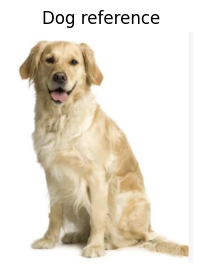

In [ ]:
# Basic preprocessing: resize to 224, convert to tensor in [0,1]
base_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

def normalize_for_clip(x: torch.Tensor) -> torch.Tensor:
    # x: (B,3,H,W) in [0,1]
    return (x - CLIP_MEAN) / CLIP_STD

# Load dog reference image
dog_pil = Image.open(dog_path).convert("RGB")
dog_tensor = base_transform(dog_pil).unsqueeze(0).to(device)  # (1,3,224,224)

with torch.no_grad():
    dog_feat = clip_model.get_image_features(pixel_values=normalize_for_clip(dog_tensor))
dog_feat = dog_feat / dog_feat.norm(dim=-1, keepdim=True)  # unit vector

print("Dog feature shape:", dog_feat.shape)

plt.figure(figsize=(3,3))
plt.imshow(dog_pil); plt.axis("off"); plt.title("Dog reference")
plt.show()


# Cell 6 – helper to load a random batch of training images

In [ ]:
def load_random_batch(image_paths: List[str], batch_size: int = 16) -> torch.Tensor:
    """Return batch of (B,3,224,224) in [0,1]. Allows sampling with replacement."""
    if len(image_paths) == 0:
        raise RuntimeError("No images in image_paths")


    if len(image_paths) >= batch_size:
        batch_paths = random.sample(image_paths, batch_size)
    else:
        batch_paths = random.choices(image_paths, k=batch_size)

    imgs = []
    for p in batch_paths:
        pil = Image.open(p).convert("RGB")
        imgs.append(base_transform(pil))
    return torch.stack(imgs, dim=0).to(device)


# Cell 7 – patch representation and patch-pasting function

In [ ]:
PATCH_SIZE = 96  # square patch (in pixels) on a 224x224 image

# Initialize patch as random noise in [0,1]
patch = torch.rand(1, 3, PATCH_SIZE, PATCH_SIZE, device=device, requires_grad=True)

def apply_patch_batch(
    imgs: torch.Tensor,
    patch: torch.Tensor,
    scale_range=(0.7, 1.3),
) -> torch.Tensor:
    """
    imgs : (B,3,H,W) in [0,1]
    patch: (1,3,P,P) in [0,1]
    Each image gets patch with random scale & random location.
    """
    B, C, H, W = imgs.shape
    P = PATCH_SIZE
    patched = imgs.clone()

    for i in range(B):
        # Random scale
        s = float(torch.empty(1).uniform_(*scale_range))
        ph = int(P * s)
        pw = ph

        # Resize patch
        patch_resized = torch.nn.functional.interpolate(
            patch, size=(ph, pw), mode="bilinear", align_corners=False
        )[0]  # (3,ph,pw)

        # Random location
        top = torch.randint(0, H - ph + 1, (1,)).item()
        left = torch.randint(0, W - pw + 1, (1,)).item()

        patched[i, :, top:top+ph, left:left+pw] = patch_resized

    return patched.clamp(0,1)


# Cell 8 – training loop for the universal patch

In [ ]:
cos = nn.CosineSimilarity(dim=-1)
optimizer = torch.optim.Adam([patch], lr=1e-2)

num_steps = 400
batch_size = 16
scale_range = (0.7, 1.3)

for step in range(num_steps):
    xb = load_random_batch(image_paths, batch_size=batch_size)  # (B,3,224,224)

    # Apply patch
    xb_patched = apply_patch_batch(xb, patch, scale_range=scale_range)

    # Normalize for CLIP
    xb_patched_norm = normalize_for_clip(xb_patched)

    # Get image features
    feats = clip_model.get_image_features(pixel_values=xb_patched_norm)
    feats = feats / feats.norm(dim=-1, keepdim=True)

    # Dog-target loss: maximize cosine similarity with dog_feat
    # ⇒ minimize (1 - cos)
    loss = (1 - cos(feats, dog_feat)).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Keep patch valid
    with torch.no_grad():
        patch.clamp_(0.0, 1.0)

    if step % 20 == 0:
        print(f"Step {step}/{num_steps} | loss = {loss.item():.4f}")


Step 0/400 | loss = 0.4178
Step 20/400 | loss = 0.3349
Step 40/400 | loss = 0.2798
Step 60/400 | loss = 0.2474
Step 80/400 | loss = 0.2081
Step 100/400 | loss = 0.2125
Step 120/400 | loss = 0.1837
Step 140/400 | loss = 0.1973
Step 160/400 | loss = 0.1812
Step 180/400 | loss = 0.1745
Step 200/400 | loss = 0.1958
Step 220/400 | loss = 0.1743
Step 240/400 | loss = 0.1582
Step 260/400 | loss = 0.1627
Step 280/400 | loss = 0.1706
Step 300/400 | loss = 0.1359
Step 320/400 | loss = 0.1605
Step 340/400 | loss = 0.1497
Step 360/400 | loss = 0.1506
Step 380/400 | loss = 0.1596


# Cell 9 – visualize the learned patch and test the patch on a random base image

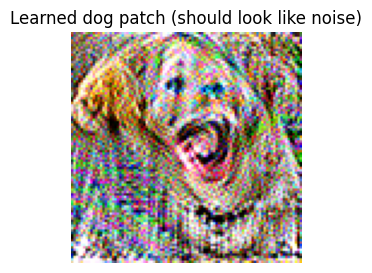

Clean→Dog similarity   : 0.5516142845153809
Patched→Dog similarity : 0.8706530928611755


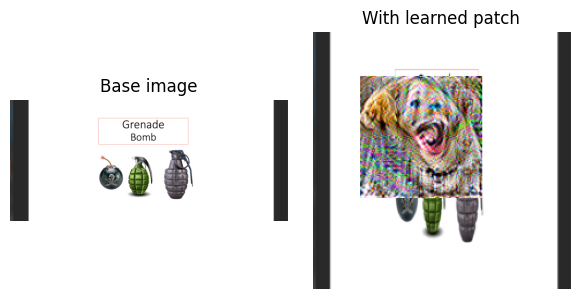

In [ ]:
patch_img = patch.detach().cpu().squeeze(0)
patch_pil = T.ToPILImage()(patch_img)

plt.figure(figsize=(3,3))
plt.imshow(patch_pil); plt.axis("off"); plt.title("Learned dog patch (should look like noise)")
plt.show()

# Test on a random base image
test_path = random.choice(image_paths)
test_pil = Image.open(test_path).convert("RGB")
test_tensor = base_transform(test_pil).unsqueeze(0).to(device)  # (1,3,224,224)

with torch.no_grad():
    clean_feat = clip_model.get_image_features(pixel_values=normalize_for_clip(test_tensor))
    clean_feat = clean_feat / clean_feat.norm(dim=-1, keepdim=True)
    clean_sim = cos(clean_feat, dog_feat).item()

patched_test_tensor = apply_patch_batch(test_tensor, patch)[0].unsqueeze(0)
with torch.no_grad():
    patched_feat = clip_model.get_image_features(pixel_values=normalize_for_clip(patched_test_tensor))
    patched_feat = patched_feat / patched_feat.norm(dim=-1, keepdim=True)
    patched_sim = cos(patched_feat, dog_feat).item()

print("Clean→Dog similarity   :", clean_sim)
print("Patched→Dog similarity :", patched_sim)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(test_pil); plt.axis("off"); plt.title("Base image")
plt.subplot(1,2,2); plt.imshow(T.ToPILImage()(patched_test_tensor[0].cpu())); plt.axis("off"); plt.title("With learned patch")
plt.tight_layout(); plt.show()


# Cell 10 – save the patch for later use

In [ ]:
save_dir = "/content/drive/MyDrive/Research/defense(for_patch_injection_attack)/data/images"
os.makedirs(save_dir, exist_ok=True)

patch_path_pt = os.path.join(save_dir, "dog_patch_tensor.pt")
patch_path_png = os.path.join(save_dir, "dog_patch_visual.png")

torch.save(patch.detach().cpu(), patch_path_pt)
patch_pil.save(patch_path_png)

print("Saved patch tensor to:", patch_path_pt)
print("Saved patch image  to:", patch_path_png)


Saved patch tensor to: /content/drive/MyDrive/Research/defense(for_patch_injection_attack)/data/images/dog_patch_tensor.pt
Saved patch image  to: /content/drive/MyDrive/Research/defense(for_patch_injection_attack)/data/images/dog_patch_visual.png
